Hyperfine couplings a_j: [3141592.65358979 3141592.65358979]
Analytic collective Ω/2π = 0.707 MHz
Using B0 = 0.0003 T
ωe/2π = 0.14 MHz, ωn/2π = 0.01 MHz


c:\git\sq\.venv\Lib\site-packages\qutip\solver\options.py:7: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


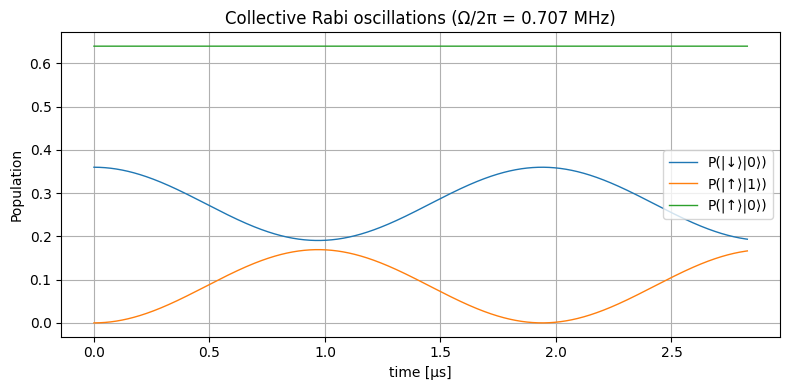

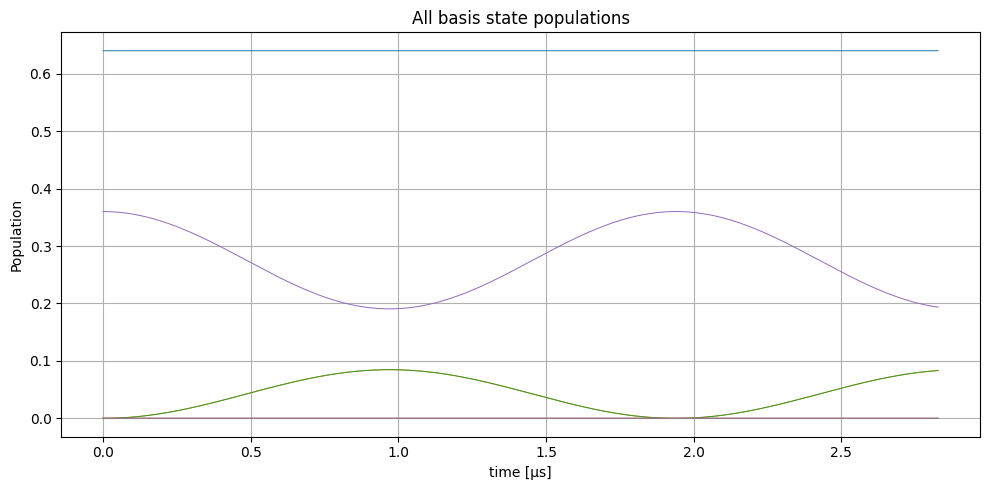

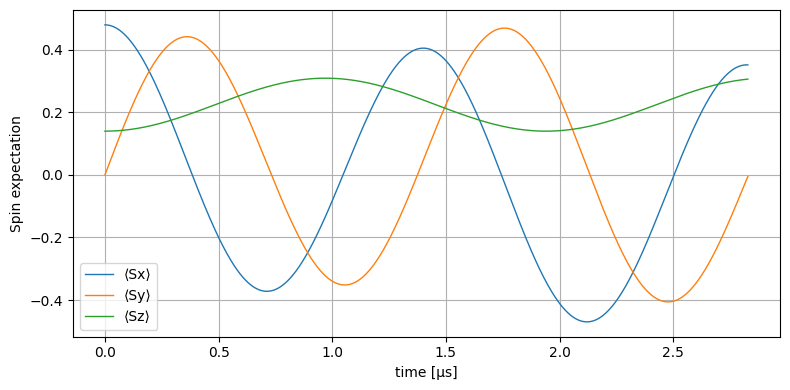

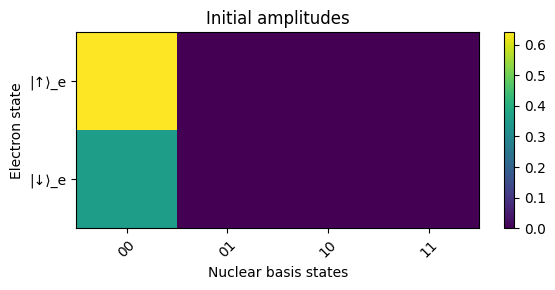

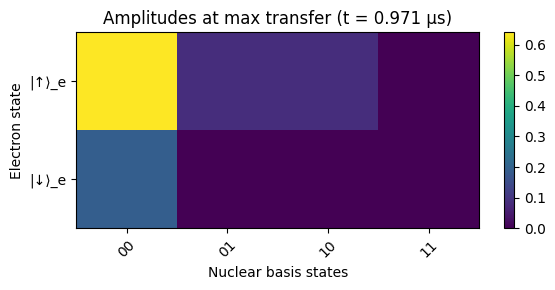

DIAGNOSTICS
gmuB        : 3141592653.5897927
gnumun      : 314159265.3589793
Used B0 (T) : 0.0002777777777777778
Ω/2π (MHz) : 0.7071067811865475
swap time t = π/Ω = 0.7071 µs
Max fidelity to target state: 0.16941167693099454
Time of max: 0.9706358216987927 µs


In [ ]:
# ============================================================================
# Quantum Memory Simulation Framework
# Electron + N Nuclear Spins (spin-1/2)
# Includes:
#  - Optional ESR / NMR drives
#  - Optional diagonal hyperfine
#  - Optional inhomogeneous hyperfine couplings
#  - Optional resonant B-field calculation (Taylor)
#  - Optional nuclear dipole–dipole coupling
#  - Full diagnostics, basis populations, spin expectations, heatmaps
#  - Arbitrary n_nuclei (>=1)
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import qutip
from qutip import SolverOptions

# ============================================================================
# B0(t) CONTROL PROFILES
# ============================================================================
def B0_res(t, args):
    """
    Constant resonant field
    """
    return args["B_res"]

def B0_step(t, args):
    """
    Instantaneous step: detuned -> resonant -> detuned
    """
    t_on  = args["t_on"]
    t_off = args["t_off"]
    B_det = args["B_det"]
    B_res = args["B_res"]

    if t < t_on:
        return B_det
    elif t < t_off:
        return B_res
    else:
        return B_det
    
def B0_linear(t, args):
    """
    Linear ramp from B_det to B_res between t_on and t_on + tau
    """
    t_on  = args["t_on"]
    tau   = args["tau"]
    B_det = args["B_det"]
    B_res = args["B_res"]

    if t < t_on:
        return B_det
    elif t < t_on + tau:
        return B_det + (B_res - B_det) * (t - t_on) / tau
    else:
        return B_res


def B0_sigmoid(t, args):
    """
    Smooth sigmoid ramp (tanh)
    """
    t0    = args["t0"]
    tau   = args["tau"]
    B_det = args["B_det"]
    B_res = args["B_res"]

    return B_det + (B_res - B_det) * 0.5 * (1 + np.tanh((t - t0) / tau))

# ============================================================================
# CONFIGURATION SWITCHES
# ============================================================================
np.random.seed(0)

USE_ESR = False
USE_NMR = False
USE_RND_HF = False     # random a_j
USE_HF_D = True        # include Ising hyperfine term (B_eff = 0)
USE_B_RES = True      # compute B0_res according to Taylor
USE_DD = False         # include nuclear dipole–dipole coupling
SUPPRESS_LEGENDS = False  # hides legends automatically for large Hilbert spaces
USE_Z = True        # enable Zeeman Hamiltonians

# NEW -------------------------------------------------------------------------
USE_INCOMPLETE_POLARIZATION = False      # <<<<<< enable incomplete polarization
POLARIZATION_P = 0.9                   # probability a nucleus starts in |0>
# -----------------------------------------------------------------------------

# ============================================================================
# PHYSICAL PARAMETERS
# ============================================================================
MHz = 1e6
n_nuclei = 2

# fallback field if not using B_res
B0_fallback = 0.1  # Tesla

# effective g-factors (chosen to give 50 MHz and 5 MHz Zeeman splittings at 0.1T)
gmuB = 2*np.pi*50e6 / 0.1     # electron (rad/s/T)
gnumun = 2*np.pi*5e6 / 0.1    # nuclear (rad/s/T)

# Hyperfine parameters
a_mean = 2*np.pi*0.5*MHz

# ESR / NMR drives (placeholders)
omega_1_MW = 2*np.pi*0.05*MHz
omega_MW   = 2*np.pi*5*MHz
omega_1_RF = 2*np.pi*0.02*MHz
omega_RF   = 2*np.pi*1*MHz

# ============================================================================
# OPERATORS
# ============================================================================
sx, sy, sz = 0.5*qutip.sigmax(), 0.5*qutip.sigmay(), 0.5*qutip.sigmaz()
sp, sm = qutip.sigmap(), qutip.sigmam()

def e(op):
    """Electron operator."""
    return qutip.tensor([op] + [qutip.qeye(2) for _ in range(n_nuclei)])

def n(op, k):
    """Operator acting on nuclear spin k."""
    ops = [qutip.qeye(2)]*(1+n_nuclei)
    ops[k+1] = op
    return qutip.tensor(ops)

# ============================================================================
# HYPERFINE COUPLINGS
# ============================================================================
if USE_RND_HF:
    a_list = a_mean * np.random.uniform(0.5, 1.5, n_nuclei)
else:
    a_list = np.array([a_mean]*n_nuclei)

Omega_est = np.sqrt(np.sum(a_list**2))
print("Hyperfine couplings a_j:", a_list)
print("Analytic collective Ω/2π = %.3f MHz" % (Omega_est/(2*np.pi)/1e6))

# ============================================================================
# RESONANT B-FIELD (TAYLOR)
# ============================================================================
I0 = 0.5
N = float(n_nuclei)
a_bar = np.mean(a_list)
A_total = np.sum(a_list)

numerator = I0 * a_bar + (I0 - 1) * (a_bar/N)
denom = (gmuB - gnumun)
#B0_res = numerator / denom if denom != 0 else B0_fallback
B0_res = - (0.5*A_total*(1 - 1/N)) / denom if denom != 0 else B0_fallback

B0 = B0_res if USE_B_RES else B0_fallback
omega_eZ = gmuB * B0
omega_NZ = gnumun * B0

print("Using B0 = %.4f T" % B0)
print("ωe/2π = %.2f MHz, ωn/2π = %.2f MHz" %
      (omega_eZ/(2*np.pi)/1e6, omega_NZ/(2*np.pi)/1e6))

# ============================================================================
# HAMILTONIAN CONSTRUCTION
# ============================================================================
# Zeeman operators (field-independent)
H_eZ_op = gmuB * e(sz)
H_NZ_op = gnumun * sum(n(sz, k) for k in range(n_nuclei))
H_B = H_eZ_op + H_NZ_op

# hyperfine
H_D = sum(a_list[k] * e(sz) * n(sz,k) for k in range(n_nuclei))
H_Omega = sum(0.5 * a_list[k] * (e(sp) * n(sm,k) + e(sm) * n(sp,k))
              for k in range(n_nuclei))

H_hf = H_Omega + (H_D if USE_HF_D else 0)

# Optional: nuclear dipole–dipole coupling
def dipolar_term(j, k, strength=1e3):
    """Simplified dipole–dipole interaction (Hz-scale)."""
    return strength * (n(sx,j) * n(sx,k) + n(sy,j) * n(sy,k) + n(sz,j) * n(sz,k)
                       - 3 * n(sz,j) * n(sz,k))

H_DD = 0
if USE_DD:
    for j in range(n_nuclei):
        for k in range(j+1, n_nuclei):
            H_DD += dipolar_term(j, k, strength=2*np.pi*1e3)  # ~1 kHz coupling

# drives
H_esr = [[omega_1_MW*e(sx), "cos(wmw*t)"],
         [-omega_1_MW*e(sy), "sin(wmw*t)"]]
H_nmr = [[omega_1_RF*n(sx,k), "cos(wrf*t)"] for k in range(n_nuclei)]

# assemble Hamiltonian
#H = [(H_eZ + H_NZ if USE_Z else 0) + H_hf + (H_DD if USE_DD else 0)]
H = [
    H_hf,
    [H_B, B0_res]
]

if USE_ESR: H += H_esr
if USE_NMR: H += H_nmr

# ============================================================================
# INITIAL STATE
# ============================================================================
up = qutip.basis(2,0)
down = qutip.basis(2,1)

# electron superposition
alpha, beta = 0.8, 0.6 # Usually, I take 0.8, 0.6
alpha, beta = alpha/np.sqrt(alpha**2+beta**2), beta/np.sqrt(alpha**2+beta**2)

# NEW ========================================================================
# INCOMPLETE POLARIZATION INITIAL NUCLEAR STATE
# ============================================================================
if USE_INCOMPLETE_POLARIZATION:
    nuclear_state_list = []
    for _ in range(n_nuclei):
        if np.random.rand() < POLARIZATION_P:
            nuclear_state_list.append(up)
        else:
            nuclear_state_list.append(down)
    nuclear_state = qutip.tensor(nuclear_state_list)
else:
    nuclear_state = qutip.tensor([up]*n_nuclei)

psi0 = qutip.tensor(alpha*up + beta*down, nuclear_state)

# ============================================================================
# TIME GRID
# ============================================================================
t_swap = np.pi / Omega_est
tmax = 4 * t_swap
tgrid = np.linspace(0, tmax, 2000)

# ============================================================================
# CONTROL SEQUENCE PARAMETERS
# ============================================================================

B_det = 0.3        # strongly detuned field (Tesla)
B_res = B0_res    # resonant field

t_on   = 0 * t_swap # 0.5 -> why does this not work?
t_off  = t_on + t_swap#1.5 * t_swap
tau    = 0.2 * t_swap

B0_args = dict(
    B_det=B_det,
    B_res=B_res,
    t_on=t_on,
    t_off=t_off,
    t0=t_on,
    tau=tau
)

# ============================================================================
# EXPECTATION OPERATORS
# ============================================================================
P_up_e = e(up*up.dag())
P_up_n = [n(up*up.dag(), k) for k in range(n_nuclei)]
S_ops = [e(sx), e(sy), e(sz)]

e_ops = [P_up_e] + P_up_n + S_ops

# ============================================================================
# SOLVE
# ============================================================================
#result = qutip.sesolve(H, psi0, tgrid, e_ops=e_ops,
#                       args={"wmw":omega_MW,"wrf":omega_RF},
#                       options=SolverOptions(store_states=True))

result = qutip.sesolve(
    H,
    psi0,
    tgrid,
    e_ops=e_ops,
    args=B0_args,
    options=SolverOptions(store_states=True)
)

states_t = result.states
expect = np.array(result.expect)

P_e_up_t = expect[0]
P_n_up_t = expect[1:1+n_nuclei]
Sx_t, Sy_t, Sz_t = expect[1+n_nuclei:1+n_nuclei+3]

# ============================================================================
# BUILD COLLECTIVE STATE |1>_n
# ============================================================================
single_flip_states = []
for k in range(n_nuclei):
    flips = [up]*n_nuclei
    flips[k] = down
    single_flip_states.append(qutip.tensor(flips))

norm = np.sqrt(np.sum(a_list**2))
n1 = sum(a_list[k]*single_flip_states[k] for k in range(n_nuclei))/norm

phi_initial = qutip.tensor(down, qutip.tensor([up]*n_nuclei))
phi_target = qutip.tensor(up, n1)
phi_up_0 = qutip.tensor(up, qutip.tensor([up]*n_nuclei))

P_initial = np.array([np.abs(phi_initial.overlap(psi))**2 for psi in states_t])
P_target  = np.array([np.abs(phi_target.overlap(psi))**2 for psi in states_t])
P_up0     = np.array([np.abs(phi_up_0.overlap(psi))**2 for psi in states_t])

# ============================================================================
# FULL BASIS POPULATIONS
# ============================================================================
dim = 2*(2**n_nuclei)
probs = np.zeros((len(states_t), dim))

for i, psi in enumerate(states_t):
    vec = psi.full().flatten()
    probs[i,:] = np.abs(vec)**2

# ============================================================================
# PLOTTING
# ============================================================================

# ---------- 1) Rabi oscillations ----------
plt.figure(figsize=(8,4))
plt.plot(tgrid * 1e6, P_initial, lw=1, label="P(|↓⟩|0⟩)")
plt.plot(tgrid * 1e6, P_target, lw=1, label="P(|↑⟩|1⟩)")
plt.plot(tgrid * 1e6, P_up0, lw=1, label="P(|↑⟩|0⟩)")

plt.xlabel("time [µs]")
plt.ylabel("Population")
plt.title("Collective Rabi oscillations (Ω/2π = %.3f MHz)" %
          (Omega_est/(2*np.pi)/1e6))
if not SUPPRESS_LEGENDS: plt.legend()
plt.grid(); plt.tight_layout(); plt.show()

# ---------- 2) All basis state populations ----------
plt.figure(figsize=(10,5))
for k in range(dim):
    plt.plot(tgrid*1e6, probs[:,k], lw=.7)
plt.xlabel("time [µs]")
plt.ylabel("Population")
plt.title("All basis state populations")
plt.grid(); plt.tight_layout(); plt.show()

# ---------- 3) Spin expectations ----------
plt.figure(figsize=(8,4))
plt.plot(tgrid*1e6, Sx_t, lw=1, label="⟨Sx⟩")
plt.plot(tgrid*1e6, Sy_t, lw=1, label="⟨Sy⟩")
plt.plot(tgrid*1e6, Sz_t, lw=1, label="⟨Sz⟩")
plt.xlabel("time [µs]")
plt.ylabel("Spin expectation")
if not SUPPRESS_LEGENDS: plt.legend()
plt.grid(); plt.tight_layout(); plt.show()

# ---------- 4) Amplitude heatmaps ----------
def plot_amp_matrix(psi, title):
    vec = psi.full().flatten()
    mat = vec.reshape((2, 2**n_nuclei))
    fig, ax = plt.subplots(figsize=(6,3))
    im = ax.imshow(np.abs(mat)**2, aspect='auto')
    plt.colorbar(im, ax=ax)

    labels = [format(i, f'0{n_nuclei}b') for i in range(2**n_nuclei)]
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45)

    ax.set_yticks([0,1])
    ax.set_yticklabels(["|↑⟩_e","|↓⟩_e"])
    ax.set_xlabel("Nuclear basis states")
    ax.set_ylabel("Electron state")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_amp_matrix(states_t[0], "Initial amplitudes")
imax = np.argmax(P_target)
plot_amp_matrix(states_t[imax],
                "Amplitudes at max transfer (t = %.3f µs)" %
                (tgrid[imax]*1e6))

# ---------- 5) Diagnostics ----------
print("======================================================")
print("DIAGNOSTICS")
print("gmuB        :", gmuB)
print("gnumun      :", gnumun)
print("Used B0 (T) :", B0)
print("Ω/2π (MHz) :", Omega_est/(2*np.pi)/1e6)
print("swap time t = π/Ω = %.4f µs" % (np.pi/Omega_est*1e6))
print("Max fidelity to target state:", np.max(P_target))
print("Time of max:", tgrid[np.argmax(P_target)]*1e6, "µs")
print("======================================================")
